In [ ]:
# modules used
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import math
import jax
import jax.numpy as jnp
import sympy as sp

In [42]:
a = 3
b = 5 
# swap 
a, b = b, a
print(a, b)

5 3


### Questions

Q1. How many multiplications and additions do you need to perform a matrix multiplication between a (n, k) and (k, m) matrix? Explain.

#### Ans/explanation:

Given two matrices $A$ and $B$:

$$A = \begin{pmatrix} a_{11} & a_{12} & \cdots & a_{1k} \\ a_{21} & a_{22} & \cdots & a_{2k} \\ \vdots & \vdots & \ddots & \vdots \\ a_{n1} & a_{n2} & \cdots & a_{nk} \end{pmatrix}, \quad B = \begin{pmatrix} b_{11} & b_{12} & \cdots & b_{1m} \\ b_{21} & b_{22} & \cdots & b_{2m} \\ \vdots & \vdots & \ddots & \vdots \\ b_{k1} & b_{k2} & \cdots & b_{km} \end{pmatrix}$$

Their product $C = AB$ is an $n \times m$ matrix:

$$C = \begin{pmatrix} c_{11} & c_{12} & \cdots & c_{1m} \\ c_{21} & c_{22} & \cdots & c_{2m} \\ \vdots & \vdots & \ddots & \vdots \\ c_{n1} & c_{n2} & \cdots & c_{nm} \end{pmatrix}$$

Where each element $c_{ij}$ is the dot product of the $i$-th row of $A$ and the $j$-th column of $B$.

For example, the element $c_{22}$ would be:

$$c_{22} = a_{21}b_{12} + a_{22}b_{22} + \cdots + a_{2k}b_{k2}$$

$$ \text{Total multiplications count} = \text{multiplications count in } c_{ij} * \text{No of elements in matrix C}$$
$$ \text{Total multiplications count} = k * n * m $$

Similarly, the total number of additions is:
$$ \text{Total additions count} = (k - 1) * n * m$$

Q2. Write Python code to multiply the above two matrices. Solve using list of lists and then use numpy. Compare the timing of both solutions. Which one is faster? Why?

In [34]:
def generate_matrix_list(rows, cols, lb=1, ub=100):
    return [[random.randint(lb, ub) for _ in range(cols)] for _ in range(rows)]

In [35]:
def list_matrix_multiply(A, B):
    n = len(A)
    k = len(B)
    m = len(B[0])
    C = [[0] * m for _ in range(n)]
    for i in range(n):
        for j in range(m):
            for l in range(k):
                C[i][j] += A[i][l] * B[l][j]
    return C

In [36]:
def benchmark(dim):
    A = generate_matrix_list(dim, dim)
    B = generate_matrix_list(dim, dim)

    # List multiplication
    start = time.time()
    list_matrix_multiply(A, B)
    list_time = (time.time() - start) * 1000  # in milliseconds

    # NumPy multiplication
    np_A = np.array(A)
    np_B = np.array(B)
    start = time.time()
    np.dot(np_A, np_B)
    numpy_time = (time.time() - start) * 1000  # in milliseconds

    return list_time, numpy_time

In [37]:
def run_benchmarks(start=10, end=200, step=10):
    dims = list(range(start, end + 1, step))
    list_times = []
    numpy_times = []

    for dim in dims:
        # print(f"Benchmarking for dimension: {dim}x{dim}")
        list_time, numpy_time = benchmark(dim)
        list_times.append(list_time)
        numpy_times.append(numpy_time)

    return dims, list_times, numpy_times

In [38]:
def plot_results(dims, list_times, numpy_times):
    plt.figure(figsize=(10, 6))
    plt.plot(dims, list_times, label="List of Lists", marker='o')
    plt.plot(dims, numpy_times, label="NumPy", marker='s')
    plt.xlabel("Matrix Dimension (n x n)")
    plt.ylabel("Time Taken (ms)")
    plt.title("Matrix Multiplication Time: Lists vs NumPy")
    plt.xticks(ticks=range(dims[0], dims[-1] + 1, 20))
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

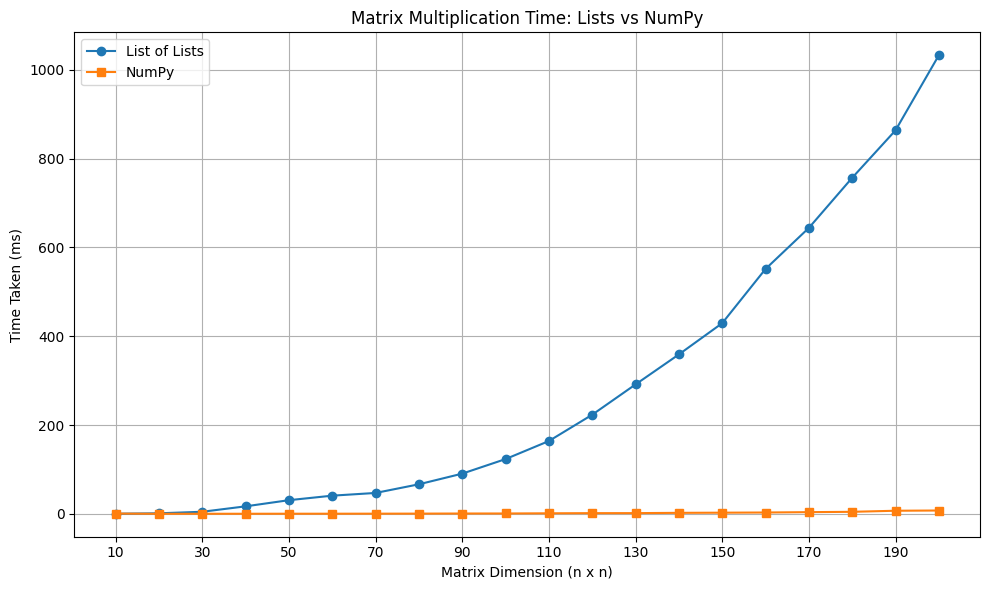

In [39]:
dims, list_times, numpy_times = run_benchmarks()
plot_results(dims, list_times, numpy_times)


#### Reason:
Python list and nested for loop approach does O(n*m*k) operations, and is of interpreted nature (not compiled), makes it slower for large matrices compared to optimized libraries like NumPy which leverage low-level optimizations (from C based libraries) and is compiled (faster) and is more efficient for large matrices.

Q3. Finding the highest element in a list requires one pass of the array. Finding the second highest element requires 2 passes of the array. Using this method, what is the time complexity of finding the median of the array? Can you suggest a better method? Can you implement both these methods in Python and compare against numpy.median routine in terms of time?

In [40]:
# approach 1: 

def make_pass(my_list):
    for pass_index in range(0, len(my_list)//2+1):
      curr_hightest_index = pass_index
      for i in range(pass_index+1, len(my_list)):
        if my_list[curr_hightest_index] < my_list[i]:
          curr_hightest_index = i
      my_list[pass_index], my_list[curr_hightest_index] = my_list[curr_hightest_index], my_list[pass_index]
    return my_list

def median_by_pass(my_list):
  make_pass(my_list)
  my_list.reverse()
  n = len(my_list)
  if n%2:
    return my_list[n//2]
  else:
    return (my_list[n//2-1] + my_list[n//2]) / 2
  
  
my_list = [100, 57, 15, 1, 12, 75, 5, 86, 89, 11]
print(f"list:\n{my_list}\n")
# profiling
start_time = time.time()
median = median_by_pass(my_list)
end_time = time.time()
print(f"median:\n{median}")
print(f"Time taken: {(end_time - start_time)*1000} milliseconds")

list:
[100, 57, 15, 1, 12, 75, 5, 86, 89, 11]

median:
36.0
Time taken: 0.03504753112792969 milliseconds


In [35]:
# approach 2: using randomized quick select
a, b = [-1], [-1] # b stores element at n/2 index, a stores for (n/2 -1)
def find_median(my_list):
  global a, b
  a, b = [-1], [-1] # Reset values for each call
  n = len(my_list)
  if n == 0:
    return None
  if n == 1:
    return my_list[0]
  if n == 2:
    return (my_list[0] + my_list[1])/2
  
  quick_select(my_list, 0, n-1, n//2, a, b)

  if n%2:
    return a[0]
  else:
    return (a[0]+b[0])/2


def quick_select(my_list, left, right, k, a, b):
  if left <= right:
    partition_index = partition(my_list, left, right)
    
    if partition_index == k:
      b[0] = my_list[partition_index]
      
      if a[0] != -1:
        return
    elif partition_index == k-1:
      a[0] = my_list[partition_index]
      if b[0] != -1:
        return
    
    if partition_index >= k:
      quick_select(my_list, left, partition_index-1, k, a, b)
    else:
      quick_select(my_list, partition_index+1, right, k, a, b)
  else:
    return


def partition(my_list, left, right):
  length = right - left + 1
  pivot_index = random.randint(0, length-1)
  my_list[left+pivot_index], my_list[right] = my_list[right], my_list[left+pivot_index]
  pivot_value = my_list[right]
  i = left
  for j in range(left, right):
    if my_list[j] < pivot_value:
      my_list[i], my_list[j] = my_list[j], my_list[i]
      i += 1 
  my_list[i], my_list[right] = my_list[right], my_list[i]
  return i

In [36]:
my_list = [100, 57, 15, 1, 12, 75, 5, 86, 89, 11]
print(f"list:\n{my_list}\n")
# profiling 
start_time = time.time()  
median = find_median(my_list=my_list)
end_time = time.time()
print(f"median:\n{median}")
print(f"Time taken: {(end_time - start_time)*1000} milliseconds")

list:
[100, 57, 15, 1, 12, 75, 5, 86, 89, 11]

median:
36.0
Time taken: 0.06508827209472656 milliseconds


In [41]:
# approach 3: using numpy
my_list = [100, 57, 15, 1, 12, 75, 5, 86, 89, 11]
print(f"list:\n{my_list}\n")

# profiling
start_time = time.time()
median = np.median(my_list)
end_time = time.time()
print(f"median:\n{median}")
print(f"Time taken: {(end_time - start_time)*1000} milliseconds")

list:
[100, 57, 15, 1, 12, 75, 5, 86, 89, 11]

median:
36.0
Time taken: 1.531839370727539 milliseconds


All above approaches are tested for very small size of list, which does not make a better comparison directly looking at time taken (depending on the machine). But the time growth rate in terms of input size $n$ of all above approaches are discussed below:

Approach 1 (using pass) takes n/2 passes, and each pass takes n-i comparisons, so total time complexity is $O(n^2)$.

Approach 2 (using randomized quick select, similar to quick sort) takes $O(n)$ time in average case, and $O(n^2)$ in worst case (whose probability is very low).

Approach 3 (using numpy) takes O(n) average time, since numpy also uses quick select internally, but highly optimized with partial sort (a variant of quick select, known as [introselect](https://stackoverflow.com/questions/50899486/why-does-numpy-median-scale-so-well) with C implementation) and it's worst case is $O(nlogn)$.

Q4. What is the gradient of the following function with respect to x and y?
$$f(x,y) = x^2y + y^3sin(x) $$

$$\frac{\partial f}{\partial x} = \frac{\partial}{\partial x}(x^2 y) + \frac{\partial}{\partial x}(y^3 \sin(x)) = 2x y + y^3 \cos(x)$$

$$\frac{\partial f}{\partial y} = \frac{\partial}{\partial y}(x^2 y) + \frac{\partial}{\partial y}(y^3 \sin(x)) = x^2 + 3y^2 \sin(x) $$

Q5. Use `JAX` to confirm the gradient evaluated by your method matches the analytical solution corresponding to a few random values of x and y

Since analytical gradient is:

$$\nabla f(x, y) = \left[ 2xy + y^3 \cos(x), \; x^2 + 3y^2 \sin(x) \right] $$

In [ ]:
def f(vec):
    x, y = vec
    return x**2 * y + y**3 * jnp.sin(x)

# Get gradient function
grad_f = jax.grad(f)

# Analytical gradient
def analytical_grad(x, y):
    df_dx = 2*x*y + y**3 * jnp.cos(x)
    df_dy = x**2 + 3*y**2 * jnp.sin(x)
    return jnp.array([df_dx, df_dy])

# few random points (x,y)
points = [
    (1.0, 2.0),
    (0.5, -1.0),
    (2.5, 0.3),
    (-1.2, 1.5)
]

for x, y in points:
    auto = grad_f(jnp.array([x, y]))
    manual = analytical_grad(x, y)
    print(f"\n(x, y) = ({x}, {y})")
    print(f"JAX grad      : {auto}")
    print(f"Manual grad   : {manual}")
    print(f"Difference    : {jnp.abs(auto - manual)}")


(x, y) = (1.0, 2.0)
JAX grad      : [ 8.322418  11.0976515]
Manual grad   : [ 8.322418  11.0976515]
Difference    : [0. 0.]

(x, y) = (0.5, -1.0)
JAX grad      : [-1.8775826  1.6882766]
Manual grad   : [-1.8775826  1.6882766]
Difference    : [0. 0.]

(x, y) = (2.5, 0.3)
JAX grad      : [1.4783691 6.4115877]
Manual grad   : [1.4783691 6.4115877]
Difference    : [0. 0.]

(x, y) = (-1.2, 1.5)
JAX grad      : [-2.3770428 -4.8512635]
Manual grad   : [-2.3770428 -4.8512635]
Difference    : [0. 0.]


Gradient difference for all points is zero, incdicating jax based grad is correct.

Q6. Use `sympy` to confirm that you obtain the same gradient analytically.

symbollically computing gradient of:

$$\nabla f(x, y) = \left[ \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right]$$

As, 

$$\nabla f(x, y) = \left[ 2xy + y^3 \cos(x), \; x^2 + 3y^2 \sin(x) \right] $$

In [46]:
# Declare symbolic variables
x, y = sp.symbols('x y')

f = x**2 * y + y**3 * sp.sin(x)

# Compute partial derivatives
df_dx = sp.diff(f, x)
df_dy = sp.diff(f, y)

print("∂f/∂x =", df_dx)
print("∂f/∂y =", df_dy)

∂f/∂x = 2*x*y + y**3*cos(x)
∂f/∂y = x**2 + 3*y**2*sin(x)


Results matches.

Q7. Create a Python nested dictionary to represent hierarchical information. We want to store record of students and their marks. Something like:

1. 2022  
   1. Branch 1  
      1. Roll Number: 1, Name: N, Marks:  
         1. Maths: 100  
         2. English: 70  
      2. Roll Number: 2, Name: M, Marks:  
         1. Maths: 90  
         2. English: 80  
   2. Branch 2  
      1. Roll Number: 3, Name: A, Marks:  
         1. Maths: 95  
         2. English: 85  

2. 2023  
   1. Branch 1  
   2. Branch 2  

3. 2024  
   1. Branch 1  
   2. Branch 2  

4. 2025  
   1. Branch 1  
   2. Branch 2  


In [ ]:
data = {
    "2022": {
        "Branch 1": [
            {
                "Roll Number": 1,
                "Name": "N",
                "Marks": {
                    "Maths": 100,
                    "English": 70
                }
            },
            {
                "Roll Number": 2,
                "Name": "M",
                "Marks": {
                    "Maths": 90,
                    "English": 80
                }
            }
        ],
        "Branch 2":
            {
            }
        
    },
    "2023": {
        "Branch 1": {},
        "Branch 2": {}
    },
    "2024": {
        "Branch 1": {},
        "Branch 2": {}
    },
    "2025": {
        "Branch 1": {},
        "Branch 2": {}
    }
}


Q8. Store the same information using Python classes. We have an overall database which is a list of year objects. Each year contains a list of branches. Each branch contains a list of students. Each student has some properties like name, roll number and has marks in some subjects.

In [49]:
class Student:
    def __init__(self, roll_number, name, marks):
        self.roll_number = roll_number
        self.name = name
        self.marks = marks 

    def __repr__(self):
        return f"Student(roll={self.roll_number}, name='{self.name}', marks={self.marks})"


class Branch:
    def __init__(self, name):
        self.name = name
        self.students = [] 

    def add_student(self, student):
        self.students.append(student)

    def __repr__(self):
        return f"Branch(name='{self.name}', students={self.students})"


class Year:
    def __init__(self, year):
        self.year = year
        self.branches = [] 

    def add_branch(self, branch):
        self.branches.append(branch)

    def __repr__(self):
        return f"Year(year={self.year}, branches={self.branches})"



database = []

year_2022 = Year(2022)

branch1_2022 = Branch("Branch 1")
branch1_2022.add_student(Student(1, "N", {"Maths": 100, "English": 70}))
branch1_2022.add_student(Student(2, "M", {"Maths": 90, "English": 80}))

branch2_2022 = Branch("Branch 2")
branch2_2022.add_student(Student(3, "A", {"Maths": 95, "English": 85}))

year_2022.add_branch(branch1_2022)
year_2022.add_branch(branch2_2022)

database.append(year_2022)


for y in [2023, 2024, 2025]:
    year = Year(y)
    year.add_branch(Branch("Branch 1"))
    year.add_branch(Branch("Branch 2"))
    database.append(year)

